In [1]:
import pandas as pd
import numpy as np
import math

from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_auc_score, make_uplift_scorer, uplift_by_percentile, qini_curve
from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import seaborn as sns

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def calculate_segments(original_data, y, uplift, treatment):
    segments = {'persuadables': 0, 'sure_things': 0, "dnd": 0, "lost_causes": 0}
    
    for dec_uplift in uplift_by_percentile(y, uplift, treatment, strategy='overall', bins=50)['uplift']:
        if dec_uplift >= 0.1:
            segments['persuadables'] += 2
        elif dec_uplift < 0.1 and dec_uplift >= 0:
            segments['sure_things'] += 2
        elif dec_uplift < 0 and dec_uplift > -0.1:
            segments['lost_causes'] += 2
        else:
            segments['dnd'] += 2
    
    for key in [*segments.keys()]:
        segments[key] = math.floor(len(original_data) * segments[key] / 100)
    
    return segments

In [3]:
A_control = pd.read_csv("data/A_target.csv")
A_cv = pd.read_csv("data/A_cv.csv")

B_treat = pd.read_csv("data/B_target.csv")
B_cv = pd.read_csv("data/B_cv.csv")


B_treat['treat'] = 1
treat_react_idx = B_treat[B_treat['customer_id'].isin(B_cv['customer_id'])]['customer_id'].index
B_treat['y'] = 0
B_treat.loc[treat_react_idx, 'y'] = 1

A_control['treat'] = 0
control_react_idx = A_control[A_control['customer_id'].isin(A_cv['customer_id'])]['customer_id'].index
A_control['y'] = 0
A_control.loc[control_react_idx, 'y'] = 1

A_control = A_control.set_index('customer_id')
B_treat = B_treat.set_index('customer_id')

print(A_control.treat.value_counts())
print(A_control.y.value_counts())
print()
print(B_treat.treat.value_counts())
print(B_treat.y.value_counts())

0    11129
Name: treat, dtype: int64
0    10948
1      181
Name: y, dtype: int64

1    11721
Name: treat, dtype: int64
0    11533
1      188
Name: y, dtype: int64


In [4]:
def smote_with_index(X, y):
    original_indices = X.index.tolist()
    over_sampler = SMOTE(random_state=123, sampling_strategy=0.1)
    X_resampled, y_resampled = over_sampler.fit_resample(X, y)

    # difference in length
    length_diff = len(X_resampled) - len(X)
    
    # assign N/A to the new rows
    new_indices = original_indices + ["N/A"] * length_diff
    X_resampled.index = new_indices
    y_resampled.index = new_indices
    
    return X_resampled, y_resampled

x_resampled_control, y_resampled_control = smote_with_index(A_control.drop(columns=['y']), A_control['y'])
x_resampled_treat, y_resampled_treat = smote_with_index(B_treat.drop(columns=['y']), B_treat['y'])

print(x_resampled_control.treat.value_counts())
print(y_resampled_control.value_counts())
print()
print(x_resampled_treat.treat.value_counts())
print(y_resampled_treat.value_counts())


0    12042
Name: treat, dtype: int64
0    10948
1     1094
Name: y, dtype: int64

1    12686
Name: treat, dtype: int64
0    11533
1     1153
Name: y, dtype: int64


In [5]:
X = pd.concat([x_resampled_control, x_resampled_treat], axis=0)

y = pd.concat([y_resampled_control, y_resampled_treat], axis=0)

df = pd.concat([X, y], axis=1)

In [6]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns=['y', 'treat'])), columns=df.columns.drop(['y', 'treat']),
                        index=df.index) 

y = df['y']
treat = df['treat']
X_scaled = X_scaled

x_train, x_test, y_train, y_test, treat_train, treat_test = train_test_split(X_scaled, y, treat, test_size=0.2, random_state=12)

In [7]:
estimator = RandomForestClassifier(min_samples_split=3, random_state=123)
ct = ClassTransformation(estimator=estimator)
ct.fit(x_train, y_train, treat_train)
uplift_ct = ct.predict(x_test)

print(uplift_at_k(y_test, uplift_ct, treat_test, strategy='by_group', k=0.3))
print(qini_auc_score(y_test, uplift_ct, treat_test))
print(uplift_auc_score(y_test, uplift_ct, treat_test))

0.27167213114754096
0.8067526939695783
0.2801771008766478


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


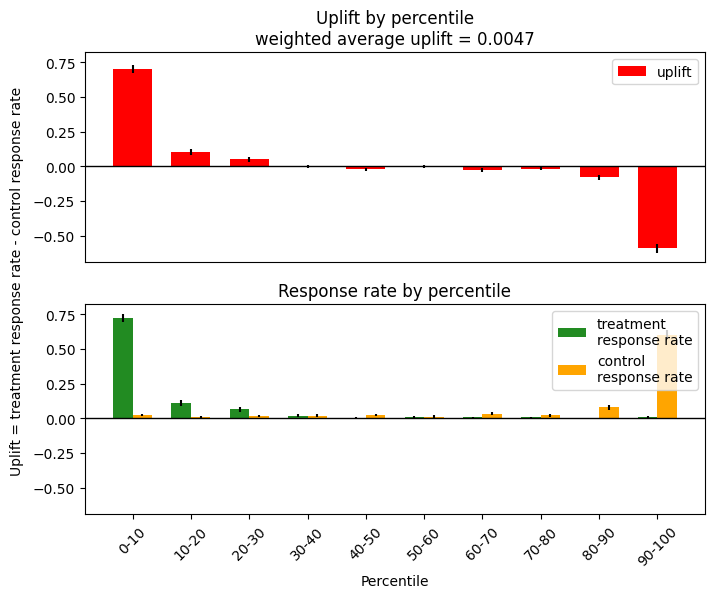

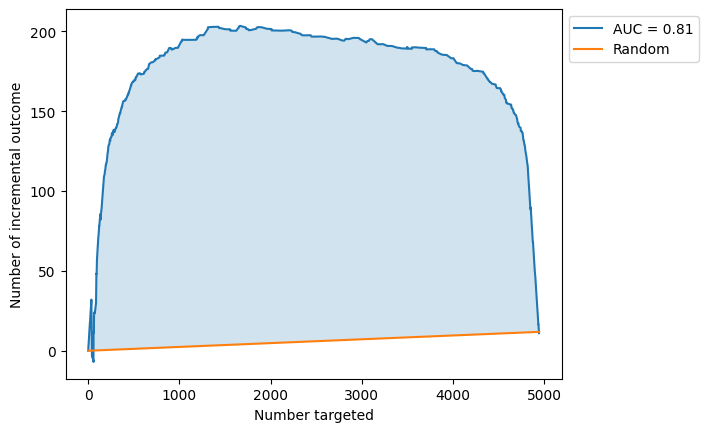

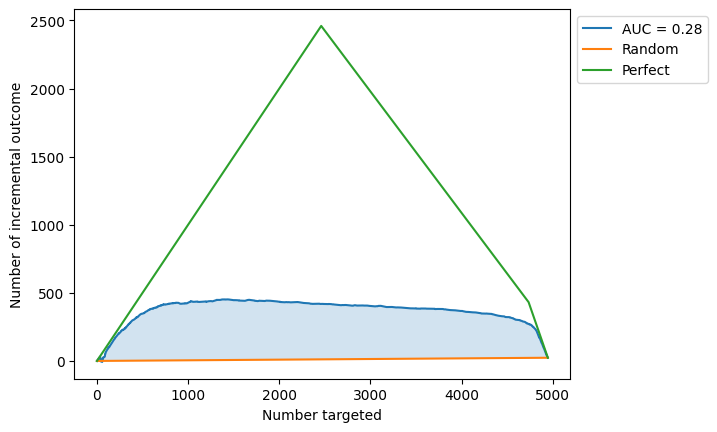

In [8]:
plot_uplift_by_percentile(y_test, uplift_ct, treat_test, kind='bar')
plot_qini_curve(y_test, uplift_ct, treat_test, perfect=False, )
plot_uplift_curve(y_test, uplift_ct, treat_test)
plt.show()

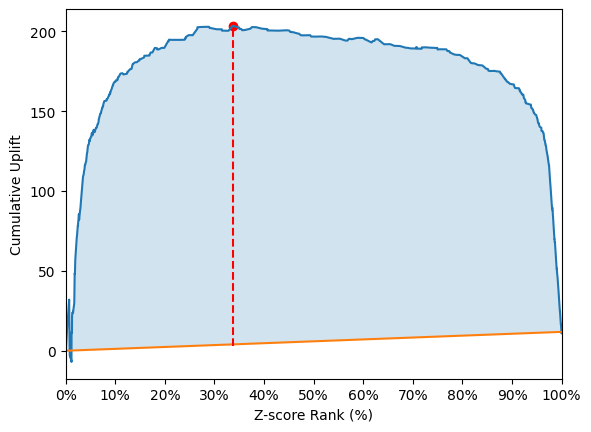

In [9]:
import matplotlib.pyplot as plt
from sklift.viz import plot_qini_curve
import numpy as np

viz = plot_qini_curve(y_true=y_test, uplift=uplift_ct, treatment=treat_test, perfect=False)
ax = plt.gca()
ax.set_xlim(0, len(y_test))

new_tick_locations = [i * len(y_test) / 10 for i in range(11)]
new_tick_labels = ["{}%".format(i * 10) for i in range(11)]

ax.set_xticks(new_tick_locations)
ax.set_xticklabels(new_tick_labels)

ax.set_xlabel('Z-score Rank (%)')
ax.set_ylabel("Cumulative Uplift")

ax.legend().remove()

y_values = viz.y_actual
x_values = viz.x_actual
max_index = np.argmax(y_values)
max_x = x_values[max_index]
max_y = y_values[max_index]

ax.scatter(max_x, max_y, color='red')

min_y = 3
ax.vlines(x=max_x, ymin=min_y, ymax=max_y, colors='red', linestyles='--')
plt.show()

In [10]:
# calculate the percentage of observations targeted to achieve the maximum cumulative uplift
percentage_max_x = (max_x / len(y_test)) * 100

print(f"The x-axis value at the maximum point is: {max_x} observations or {percentage_max_x:.2f}%")


The x-axis value at the maximum point is: 1664 observations or 33.64%


In [11]:
percentage_max_x

33.6433481601294

In [12]:
uplift_at_k(y_test, uplift_ct, treat_test, strategy='by_group', k=percentage_max_x/100)

0.24069771815264973

In [13]:
uplift_at_k(y_test, uplift_ct, treat_test, strategy='by_group', k=0.2)

0.3876065573770492

In [14]:
# Qini Curve
# 1. X-axis
#   ranges from 0 to N
#   ordering is from highest uplift to lowest uplift
#   Thus, the area under the curve is the cumulative uplift when targeting certain proportion of N,
#   this means thae treatment effect - control effect (and thus pure treatment effect) when targeting
#   certain top proportions (most responding ones) identified by the model
# 2. Y-axis
#   number of incremental outcome = cumulative uplift = conversions under treatment - conversions under control
#   Thus, cumulative uplift = conversion gains under treatment compared to control
# 3. Highest point in the graph
#   represents optimal point at which the incremental outcome (i.e., cumulative uplift) is maximized.
#   It's the point at which targeting customers based on uplift model results in the greatest additional positive outcomes (e.g., conversions)
#   compared to a control group or random targeting

In [15]:
segment = calculate_segments(df, y_test, uplift_ct, treat_test)

In [16]:
segment

{'persuadables': 4945, 'sure_things': 5440, 'dnd': 3461, 'lost_causes': 10880}

In [17]:
sum([*calculate_segments(df, y_test, uplift_ct, treat_test).values()])

24726

In [18]:
len(df)

24728

In [19]:
segment['persuadables'] + segment['sure_things']

10385

In [20]:
segment['dnd'] + segment['lost_causes']

14341

In [21]:
segment['dnd'] + segment['lost_causes'] + segment['sure_things']

19781

In [22]:
segment['lost_causes'] + segment['dnd']

14341

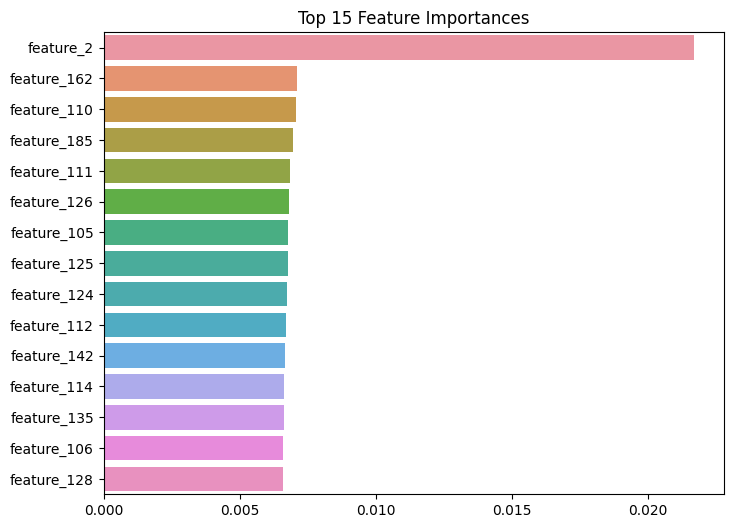

In [23]:
ser = pd.Series(ct.estimator.feature_importances_, index=x_train.columns)
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Top 15 Feature Importances')
sns.barplot(x=top15, y=top15.index)
plt.show()

In [24]:
# # For Test set res only:
# result_df = pd.DataFrame({
#     'customer_id': x_test.index,
#     'treatment/control': treat_test,  # 1 if treat=1
#     'conversion': y_test,
#     'uplift_score': uplift_ct
# })

In [25]:
X = pd.concat([x_train, x_test])
conversion = pd.concat([y_train, y_test])
treatment = pd.concat([treat_train, treat_test])
uplift_score = ct.predict(X)

In [26]:
result_df = pd.DataFrame({
    'customer_id':  X.index,
    'treatment/control': treatment,  # 1 if treat=1
    'conversion': conversion,
    'uplift_score': uplift_score
})

In [27]:
result_df[result_df['uplift_score']==result_df['uplift_score'].max()]

,customer_id,treatment/control,conversion,uplift_score
N/A,N/A,1,1,0.99
N/A,N/A,1,1,0.99


In [28]:
result_df[result_df['uplift_score']==result_df['uplift_score'].min()]

,customer_id,treatment/control,conversion,uplift_score
N/A,N/A,0,1,-1.0


In [29]:
# result_df.to_csv("uplift_result_per_customers_total.csv", index=False)

In [30]:
result_df.columns

Index(['customer_id', 'treatment/control', 'conversion', 'uplift_score'], dtype='object')

In [31]:
result_df.reset_index(drop=True).iloc[:, 1:].head()

,treatment/control,conversion,uplift_score
0,0,1,-0.546667
1,1,0,-0.710000
2,0,0,0.743333
3,0,0,0.630000
4,0,0,0.586667


In [32]:
customer_res = result_df[result_df['customer_id'] != 'N/A']

In [33]:
# customer_res.to_csv("uplift_result_per_customers_existingcustomersonly.csv", index=False)